# Hello PixelCNN using Tensorflow mixture distrobutions on MNIST dataset

In [20]:
# Prerequisites
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

# pip install tensorflow_probability[tf]
import tensorflow_probability as tfp

from utils import display

print("Python Version: ", sys.version)

Python Version:  3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]


### Get Data
Use FashionMNIST from TensorFlow datasets

In [2]:

(x_train, _), (_, _) = datasets.mnist.load_data()

### Preprocess Data

Scale down in size and image depth to make the training time reasonable

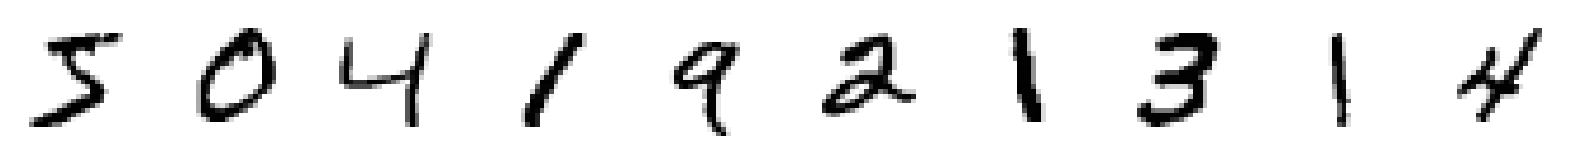

In [3]:
IMAGE_SIZE = 28 # MNIST images are 28x28 pixels

x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # (N, 28, 28, 1

# Display some sample preprocessed images
display(x_train)

### Define PixelCNN

#### Define PixelCNN itself

In [15]:
N_COMPONENTS = 5

class LogProbLayer(layers.Layer):
    def __init__(self, image_shape, **kwargs):
        super().__init__(**kwargs)
        self.image_shape = image_shape

    def build(self, input_shape):
        self.dist = tfp.distributions.PixelCNN(
            image_shape=self.image_shape,
            num_resnet=1,
            num_hierarchies=2,
            num_filters=32,
            num_logistic_mix=5,
            dropout_p=0.3,
        )

    def call(self, inputs):
        log_prob = self.dist.log_prob(inputs)
        self.add_loss(-tf.reduce_mean(log_prob))
        return log_prob
    
    def sample(self, n_samples):
        return self.dist.sample(n_samples)

In [16]:
# Keras Functional API Model
image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
log_prob_output = LogProbLayer((IMAGE_SIZE, IMAGE_SIZE, 1))(image_input)
pixelcnn = models.Model(inputs=image_input, outputs=log_prob_output)

### Compile and Train the PixelCNN

In [17]:
BATCH_SIZE = 128
EPOCHS = 10

# Compile and train the model
pixelcnn.compile(optimizer='adam')
pixelcnn.fit(x_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/10


/home/jari/MyGitHub/ML_Generative_AI_Experiments/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 1150.9664
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 1149.9579
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 1150.5063
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 1150.4104
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 1150.4988
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1150.6171
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1150.3417
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1150.7551
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1150.6869
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1151.0972


In [18]:
print(pixelcnn.summary())
print("Trainable weights: ", pixelcnn.trainable_weights)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ log_prob_layer_1 (LogProbLayer) │ (None)                 │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Trainable weights:  []


### Sample Images from trained model


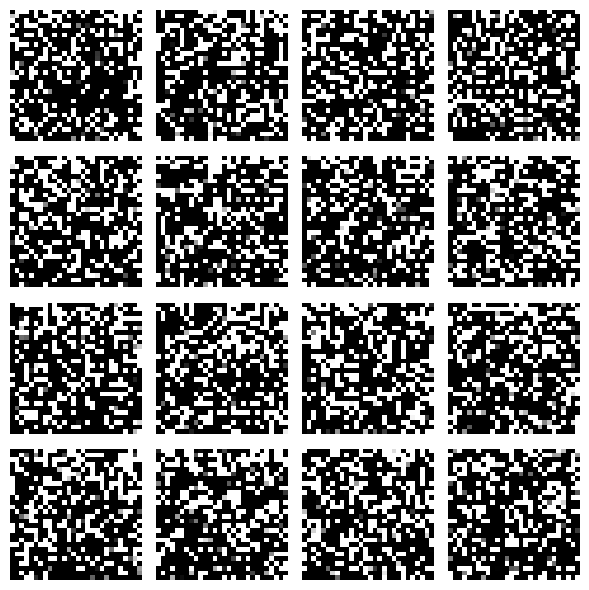

In [21]:

# Sample images from the trained model
n_samples = 16
log_prob_layer = pixelcnn.layers[-1]
generated_images = log_prob_layer.sample(n_samples)  # shape: (n_samples, 28, 28, 1)

# Display
plt.figure(figsize=(6,6))
for i in range(n_samples):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_images[i, ..., 0], cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()